In [1]:
import numpy as np
import matplotlib.pyplot as plt
from neurodsp.spectral import compute_spectrum
from timescales.sim.exp import sim_spikes_synaptic
from timescales.est.psd import fit_psd, convert_knee_val
from timescales.est.acf import fit_acf, compute_acf

### Spectral Estimation Comparisons

This notebook compares how different spectral estimation methods (welch vs medfilt vs wavelets) compare. A large tau is simulated, which is known to result in poor estimates via welch's method.

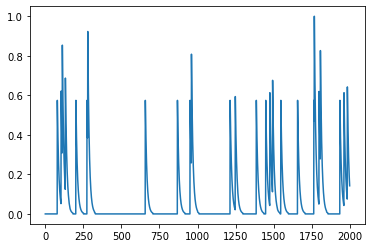

In [59]:
n_seconds = 2
fs = 1000

tau = .01
n_neurons = 1
mu = 100

probs = np.zeros((100, int(fs * n_seconds)))

for i in range(100):
    _probs, spikes = sim_spikes_synaptic(n_seconds, fs, tau, n_neurons=n_neurons)
    probs[i] = _probs
    
plt.plot(probs[0]);

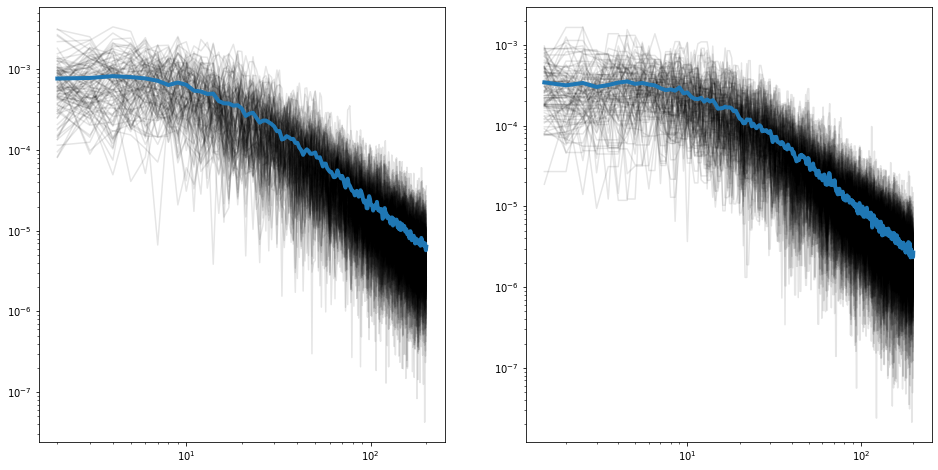

In [60]:
f_range = (1, 200)

freqs_welch, powers_welch = compute_spectrum(probs, fs, method='welch', f_range=f_range)

freqs_med, powers_med = compute_spectrum(probs, fs, method='medfilt', filt_len=1, f_range=f_range)

# Plot
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

for p in powers_welch:
    axes[0].loglog(freqs_welch[1:], p[1:], color='k', alpha=.1)
for p in powers_med:
    axes[1].loglog(freqs_med[1:], p[1:], color='k', alpha=.1)
    
    
axes[0].loglog(freqs_welch[1:], powers_welch.mean(axis=0)[1:], label='Welch', lw=4)
axes[1].loglog(freqs_med[1:], powers_med.mean(axis=0)[1:], label='MedFilt', lw=4);

In [61]:
# Fit fooof
fooof_init = {'max_n_peaks': 0}

fg_welch, kf_welch, kt_welch = fit_psd(freqs_welch, powers_welch, f_range=f_range,
                                       fooof_init=fooof_init, knee_bounds=(.5, 1000))

fg_med, kf_med, kt_med = fit_psd(freqs_med, powers_med, f_range=f_range,
                                 fooof_init=fooof_init, knee_bounds=(.5, 1000))


# Fit ACF
from scipy.fft import fft, ifft, fftfreq
"""
from scipy.fft import ifft, fftfreq

acf_welch = np.zeros((len(probs), len(fg_welch.power_spectra[0]) // 2))
acf_med= np.zeros((len(probs), len(fg_med.power_spectra[0]) // 2))

for ind, spec in enumerate(fg_welch.power_spectra):
    acf_welch[ind] = ifft(10**spec)[:len(spec)//2].real
    
for ind, spec in enumerate(fg_med.power_spectra):
    acf_med[ind] = ifft(10**spec)[:len(spec)//2].real


params_acf_welch = fit_acf(acf_welch)
params_acf_med = fit_acf(acf_med)
"""
corrs = compute_acf(probs, len(probs[0]))
params = fit_acf(corrs)

In [97]:
convert_knee_val(1)

(1.0, 0.15915494309189535)

In [100]:
convert_knee_val(.00001)

(0.0031622776601683794, 50.329212104487034)

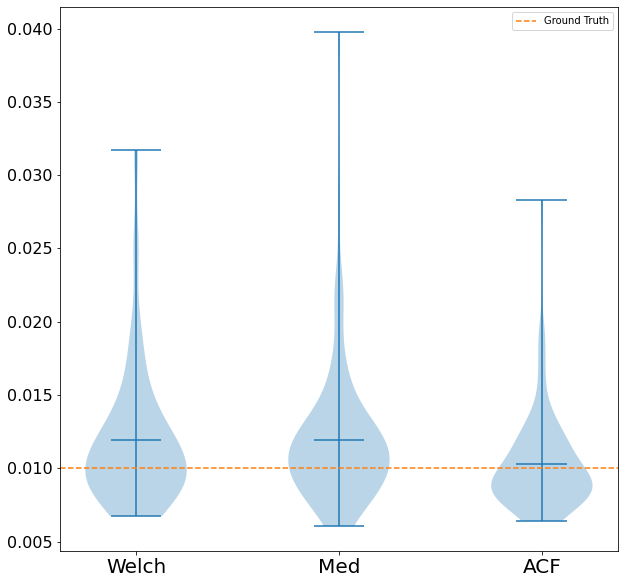

In [62]:
# Plot fooof
plt.figure(figsize=(10, 10))

plt.violinplot([kt_welch, kt_med, params[:, 0]/fs], showmeans=True)
plt.axhline(tau, color='C1', ls='dashed', label='Ground Truth')

plt.yticks(size=16)
plt.xticks([1, 2, 3], ['Welch', 'Med', 'ACF'], size=20)


plt.legend();

#fg_welch, kf_welch, kt_welch = fit_psd(freqs_welch, powers_welch.mean(axis=0), f_range=f_range,
#                                       fooof_init=fooof_init, knee_bounds=(0, 1000))

#fg_med, kf_med, kt_med = fit_psd(freqs_med, powers_med.mean(axis=0), f_range=f_range,
#                                 fooof_init=fooof_init, knee_bounds=(0, 1000))
